In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TerminateOnNaN, LearningRateScheduler
from sklearn.model_selection import train_test_split

2025-05-01 05:28:57.053290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746077337.269400      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746077337.333679      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set seeds for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Define base directory and classes
base_dir = r'/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
classes = ['Normal', 'Cyst', 'Tumor', 'Stone']
label_mapping = {'Normal': 0, 'Cyst': 1, 'Tumor': 2, 'Stone': 3}


In [4]:
def make_balanced_df(classes, base_dir, samples_per_class=1300):
    data = []
    for label in classes:
        folder_path = os.path.join(base_dir, label)
        all_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('jpg', 'png'))])
        sampled_files = np.random.choice(all_files, samples_per_class, replace=False)
        data.extend([(fp, label) for fp in sampled_files])
    df = pd.DataFrame(data, columns=['file_path', 'label'])
    df['label'] = df['label'].map(label_mapping).astype(str)
    return df

# Load balanced data
df = make_balanced_df(classes, base_dir)

In [5]:
# Split dataset deterministically
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=SEED)

In [6]:
# Data augmentation
image_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_val_generator = ImageDataGenerator(rescale=1.0/255)

# Creating generators
training_set = image_generator.flow_from_dataframe(
    dataframe=train_df, x_col='file_path', y_col='label',
    target_size=(224, 224), batch_size=32, class_mode='categorical', color_mode='rgb', shuffle=True,interpolation='bilinear'
)
test_set = test_val_generator.flow_from_dataframe(
    dataframe=test_df, x_col='file_path', y_col='label',
    target_size=(224, 224), batch_size=32, class_mode='categorical', color_mode='rgb', shuffle=False
)

validation_set = test_val_generator.flow_from_dataframe(
    dataframe=valid_df, x_col='file_path', y_col='label',
    target_size=(224, 224), batch_size=32, class_mode='categorical', color_mode='rgb', shuffle=False
)

Found 3328 validated image filenames belonging to 4 classes.
Found 1040 validated image filenames belonging to 4 classes.
Found 832 validated image filenames belonging to 4 classes.


In [7]:
# Model setup
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output_layer)

I0000 00:00:1746077404.900371      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [8]:
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [9]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max'
)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=1e-6)
csv_logger = CSVLogger('training_log.csv')
callbacks = [early_stopping, reduce_lr, model_checkpoint, csv_logger]

In [10]:
# Train the model
history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746077509.603237      90 service.cc:148] XLA service 0x7d0e5c0023b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746077509.604411      90 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746077514.755155      90 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/104 ━━━━━━━━━━━━━━━━━━━━ 1:38:23 57s/step - accuracy: 0.1875 - loss: 2.0635

I0000 00:00:1746077527.910541      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.3716 - loss: 1.7542
Epoch 1: val_accuracy improved from -inf to 0.68870, saving model to best_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 148s 884ms/step - accuracy: 0.3724 - loss: 1.7515 - val_accuracy: 0.6887 - val_loss: 0.9180 - learning_rate: 1.0000e-04
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.6500 - loss: 0.9553
Epoch 2: val_accuracy improved from 0.68870 to 0.76442, saving model to best_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 57s 518ms/step - accuracy: 0.6503 - loss: 0.9544 - val_accuracy: 0.7644 - val_loss: 0.6294 - learning_rate: 1.0000e-04
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7502 - loss: 0.6623
Epoch 3: val_accuracy improved from 0.76442 to 0.81731, saving model to best_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 57s 519ms/step - accuracy: 0.7504 - loss: 0.6618 - val_accuracy: 0.8173 - val_loss: 0.5030 - learning_rate: 1.0000e-04
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━

In [11]:
# Evaluate model
eval_result = model.evaluate(test_set)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 630ms/step - accuracy: 0.9650 - loss: 0.1041
Test Loss: 0.12009952962398529, Test Accuracy: 0.9644230604171753


In [14]:
# Save final model
model.save('/kaggle/working/InceptionResNetv2 Balanced.keras')

33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 590ms/step


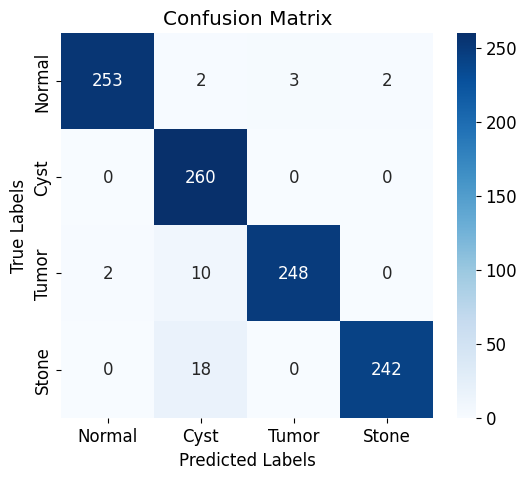

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

# Get true labels and predictions
y_true = test_set.classes  # True labels
y_pred_probs = model.predict(test_set)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class index
# Set font style globally
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
# Class names
class_names = ['Normal', 'Cyst', 'Tumor', 'Stone']
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.pdf")
plt.show()
plt.close()

In [13]:
from sklearn.metrics import classification_report
# Set font style globally
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       260
        Cyst       0.90      1.00      0.95       260
       Tumor       0.99      0.95      0.97       260
       Stone       0.99      0.93      0.96       260

    accuracy                           0.96      1040
   macro avg       0.97      0.96      0.96      1040
weighted avg       0.97      0.96      0.96      1040



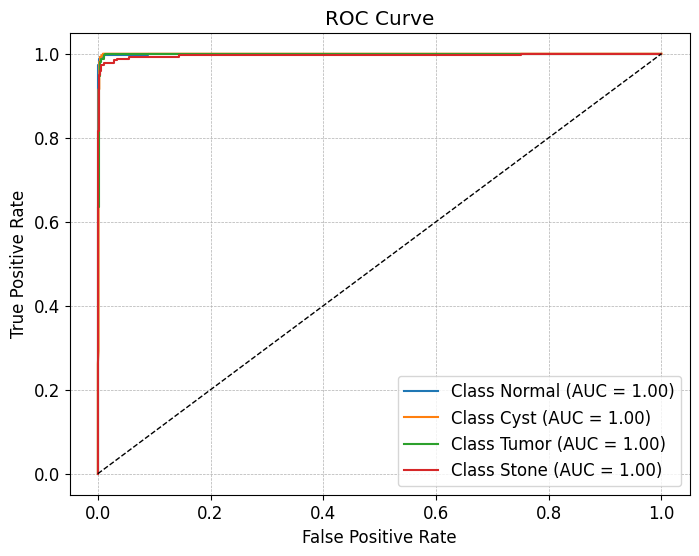

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Set font style globally
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

plt.figure(figsize=(8, 6))

# Ensure y_true is a NumPy array
y_true = np.array(y_true)
for i in range(len(class_names)):
    # Convert y_true to binary labels for class i
    y_true_binary = (y_true == i).astype(int)

    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', linewidth=0.5)
# Save and show
plt.savefig("roc_curve.pdf", bbox_inches='tight')
plt.show()
plt.close()

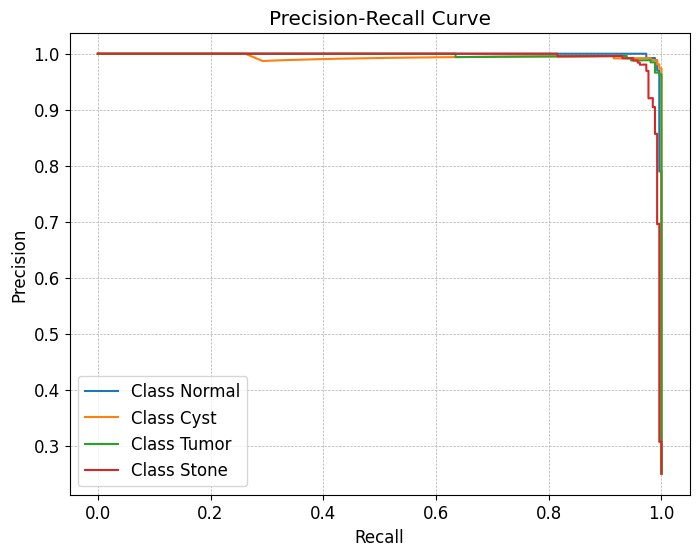

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

# Set font style globally
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

plt.figure(figsize=(8, 6))

# Ensure y_true is a NumPy array
y_true = np.array(y_true)

for i in range(len(class_names)):
    # Convert y_true to binary labels for class i
    y_true_binary = (y_true == i).astype(int)

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred_probs[:, i])

    # Plot PR curve
    plt.plot(recall, precision, label=f'Class {class_names[i]}')
# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True, linestyle='--', linewidth=0.5)

# Save and show
plt.savefig("precision_recall_curve.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [17]:
def grad_cam(model, img_array, layer_name):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)[0]
    heatmap /= np.max(heatmap)
    return heatmap

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step


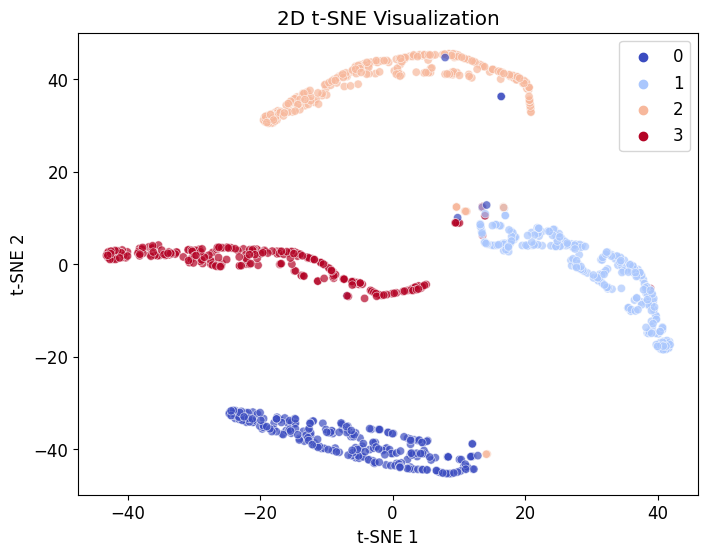

In [18]:
# t-SNE Visualization
features = model.predict(test_set)
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=y_true, palette='coolwarm', alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('2D t-SNE Visualization')
plt.legend()
plt.savefig("tsne_2d.pdf")
plt.show()
plt.close()

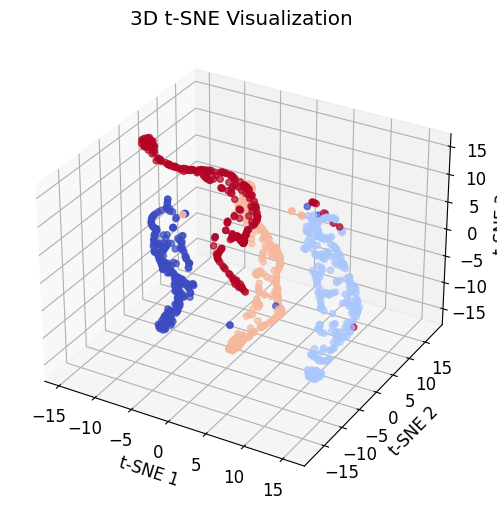

In [19]:
# 3D t-SNE
from mpl_toolkits.mplot3d import Axes3D

tsne_3d = TSNE(n_components=3, random_state=42)
features_3d = tsne_3d.fit_transform(features)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], c=y_true, cmap='coolwarm', alpha=0.7)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.title('3D t-SNE Visualization')
plt.savefig("tsne_3d.pdf")
plt.show()
plt.close()

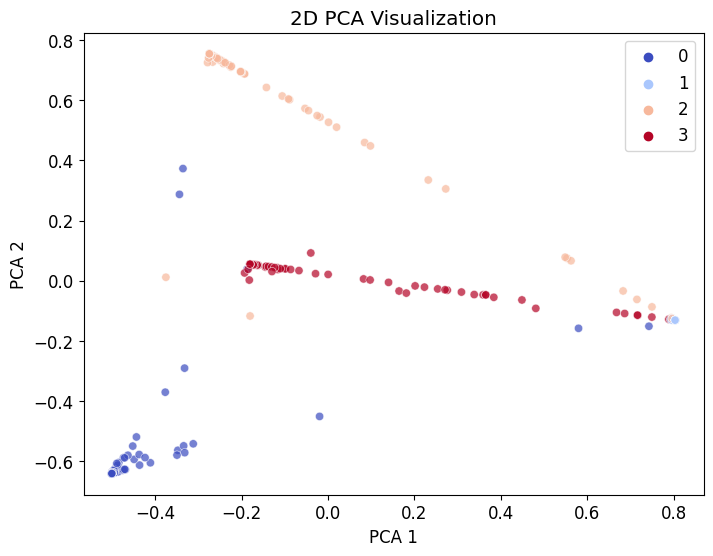

In [20]:
# PCA (2D and 3D)
pca_2d = PCA(n_components=2)
features_pca_2d = pca_2d.fit_transform(features)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_pca_2d[:, 0], y=features_pca_2d[:, 1], hue=y_true, palette='coolwarm', alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D PCA Visualization')
plt.legend()
plt.savefig("pca_2d.pdf")
plt.show()
plt.close()

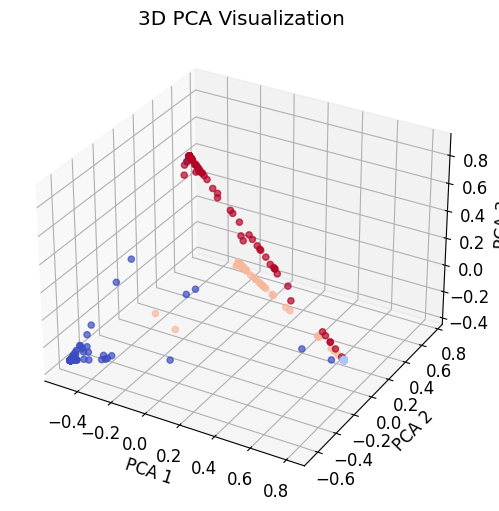

In [21]:
pca_3d = PCA(n_components=3)
features_pca_3d = pca_3d.fit_transform(features)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca_3d[:, 0], features_pca_3d[:, 1], features_pca_3d[:, 2], c=y_true, cmap='coolwarm', alpha=0.7)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.title('3D PCA Visualization')
plt.savefig("pca_3d.pdf")
plt.show()
plt.close()

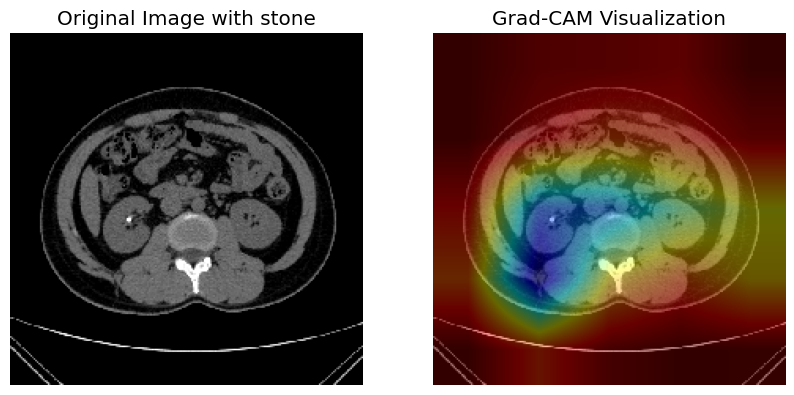

In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Function to load an image and preprocess it for the model
def preprocess_image(image_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize if required by your model
    return img_array, img

# Function to generate Grad-CAM heatmap
def generate_gradcam(model, image_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        if pred_index is None:
            pred_index = np.argmax(predictions[0])  # Take highest probability class
        class_output = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_output, conv_outputs)

    # Compute global average pooling over the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply pooled gradients with feature maps
    conv_outputs = conv_outputs[0]
    heatmap = np.mean(conv_outputs * pooled_grads, axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap
# Function to overlay heatmap on original image
def overlay_heatmap(heatmap, img, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))  # Resize heatmap to match image
    heatmap = np.uint8(255 * heatmap)  # Convert to 0-255 scale
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap

    img = np.array(img)  # Convert PIL image to NumPy array
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)  # Overlay

    return superimposed_img



# Set image path and last conv layer name
image_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (1000).jpg"  # Replace with your image
last_conv_layer_name = "conv_7b"  # Last convolutional layer in InceptionResNetV2

# Preprocess the image
image_array, img = preprocess_image(image_path)
# Generate Grad-CAM heatmap
heatmap = generate_gradcam(model, image_array, last_conv_layer_name)

# Overlay heatmap on original image
superimposed_img = overlay_heatmap(heatmap, img)

# Display results
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image with stone")
plt.axis("off")

# Grad-CAM Output
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Visualization")
plt.axis("off")
plt.savefig("Grad-CAM stone.pdf")

plt.show()

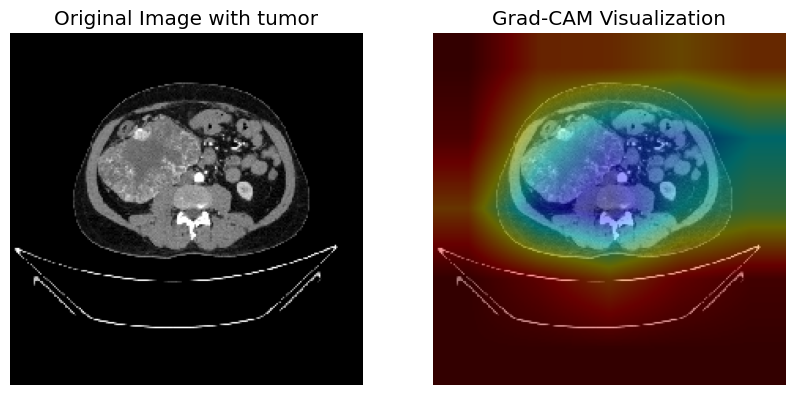

In [53]:
# Set image path and last conv layer name
image_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (100).jpg"  # Replace with your image
last_conv_layer_name = "conv_7b"  # Last convolutional layer in InceptionResNetV2

# Preprocess the image
image_array, img = preprocess_image(image_path)

# Generate Grad-CAM heatmap
heatmap = generate_gradcam(model, image_array, last_conv_layer_name)

# Overlay heatmap on original image
superimposed_img = overlay_heatmap(heatmap, img)

# Display results
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image with tumor")
plt.axis("off")
# Grad-CAM Output
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Visualization")
plt.axis("off")
plt.savefig("Grad-CAM tumor.pdf")

plt.show()

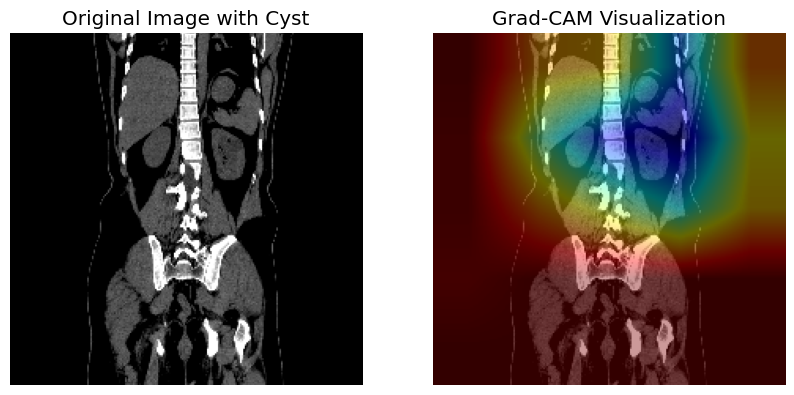

In [83]:
# Set image path and last conv layer name
image_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1024).jpg"  # Replace with your image
last_conv_layer_name = "conv_7b"  # Last convolutional layer in InceptionResNetV2

# Preprocess the image
image_array, img = preprocess_image(image_path)

# Generate Grad-CAM heatmap
heatmap = generate_gradcam(model, image_array, last_conv_layer_name)

# Overlay heatmap on original image
superimposed_img = overlay_heatmap(heatmap, img)
# Display results
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image with Cyst")
plt.axis("off")
# Grad-CAM Output
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Visualization")
plt.axis("off")
plt.savefig("Grad-CAM Cyst.pdf")
plt.show()

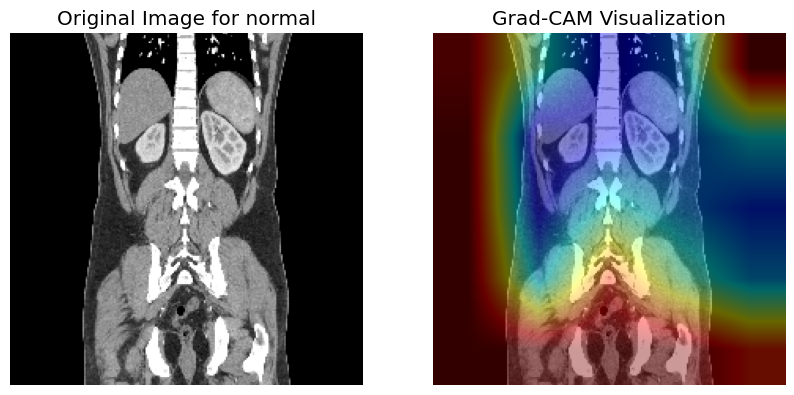

In [84]:
image_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (1051).jpg"  # Replace with your image
last_conv_layer_name = "conv_7b"  # Last convolutional layer in InceptionResNetV2

# Preprocess the image
image_array, img = preprocess_image(image_path)

# Generate Grad-CAM heatmap
heatmap = generate_gradcam(model, image_array, last_conv_layer_name)

# Overlay heatmap on original image
superimposed_img = overlay_heatmap(heatmap, img)
# Display results
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image for normal")
plt.axis("off")
# Grad-CAM Output
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Visualization")
plt.axis("off")
plt.savefig("Grad-CAM normal.pdf")
plt.show()

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Set font style globally
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

def plot_training_curves(history, save_path="training_results.pdf"):
    # Extract accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = np.arange(1, len(acc) + 1)  # Epoch numbers

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Accuracy
    ax[0].plot(epochs, acc, 'b-', label="Training Accuracy")
    ax[0].plot(epochs, val_acc, 'r-', label="Validation Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_title("Training & Validation Accuracy")
    ax[0].legend()
    ax[0].grid(True, linestyle='--', linewidth=0.5)

    # Plot Loss
    ax[1].plot(epochs, loss, 'b-', label="Training Loss")
    ax[1].plot(epochs, val_loss, 'r-', label="Validation Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].set_title("Training & Validation Loss")
    ax[1].legend()
    ax[1].grid(True, linestyle='--', linewidth=0.5)

    # Adjust layout and save as PDF
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', format='pdf')

    # Show the plots
    plt.show()
    plt.close()

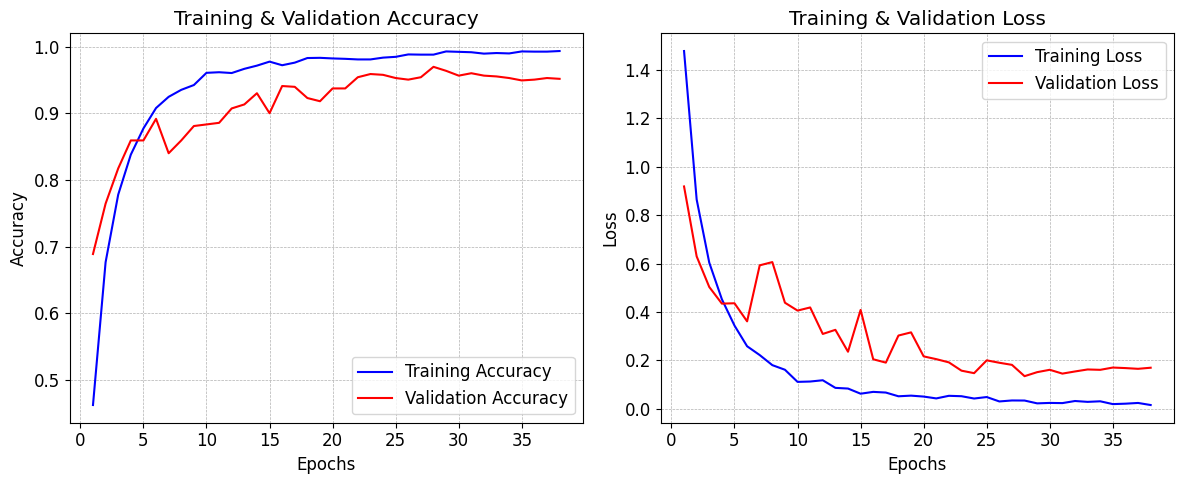

In [86]:
plot_training_curves(history, save_path="accuracy_loss_plot.pdf")

**SVM**

In [92]:
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)

In [95]:
from tqdm import tqdm

def extract_features(df):
    features = []
    labels = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        img = load_img(row['file_path'], target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        feature = feature_extractor.predict(img_array, verbose=0)
        features.append(feature.flatten())
        labels.append(row['label'])
    return np.array(features), np.array(labels)


In [97]:
# Extract features
from tensorflow.keras.preprocessing.image import load_img, img_to_array

X_train, y_train = extract_features(train_df)
X_valid, y_valid = extract_features(valid_df)
X_test, y_test = extract_features(test_df)

100%|██████████| 1040/1040 [01:49<00:00,  9.51it/s]


In [99]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


In [100]:
# Train SVM model
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_scaled, y_train)


SVC(probability=True)

In [102]:
# Evaluate
from sklearn.metrics import accuracy_score

y_pred = svm_model.predict(X_test_scaled)
print("Classification Report (SVM):")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       260
           1       0.99      1.00      1.00       260
           2       0.99      0.99      0.99       260
           3       1.00      0.99      0.99       260

    accuracy                           0.99      1040
   macro avg       0.99      0.99      0.99      1040
weighted avg       0.99      0.99      0.99      1040

Accuracy: 0.9923076923076923


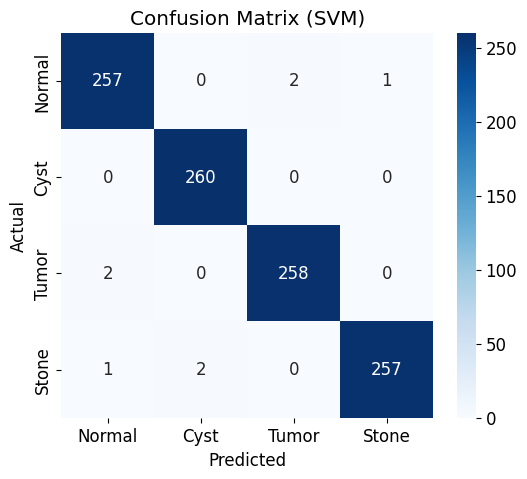

In [103]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Total misclassified images: 8


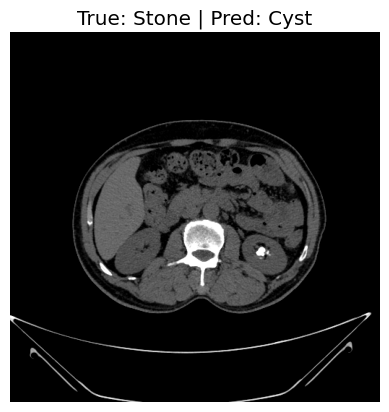

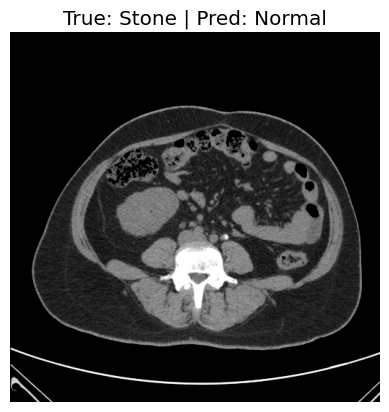

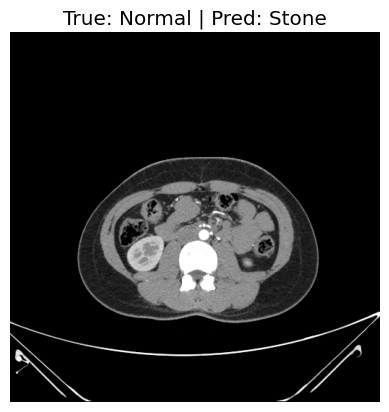

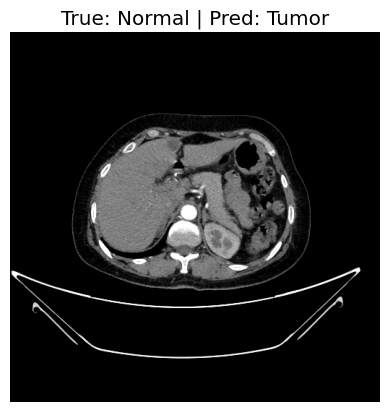

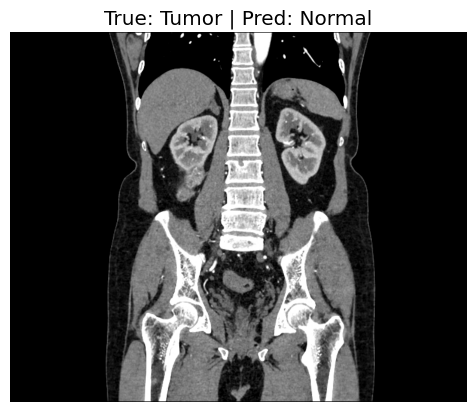

In [106]:
import matplotlib.pyplot as plt
import random
from IPython.display import display
from PIL import Image

wrong_idx = np.where(y_test != y_pred)[0]
print(f"Total misclassified images: {len(wrong_idx)}")

# Display few misclassified samples
num_samples = min(5, len(wrong_idx))
sample_idx = random.sample(list(wrong_idx), num_samples)

for idx in sample_idx:
    file_path = test_df.iloc[idx]['file_path']
    true_label = classes[int(y_test[idx])]
    pred_label = classes[int(y_pred[idx])]

    img = Image.open(file_path)
    plt.imshow(img)
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()


In [107]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [108]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)

In [109]:
# Classification Report
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred, target_names=classes))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       260
        Cyst       0.99      1.00      0.99       260
       Tumor       1.00      0.99      0.99       260
       Stone       0.99      0.99      0.99       260

    accuracy                           0.99      1040
   macro avg       0.99      0.99      0.99      1040
weighted avg       0.99      0.99      0.99      1040

Accuracy: 0.9923076923076923


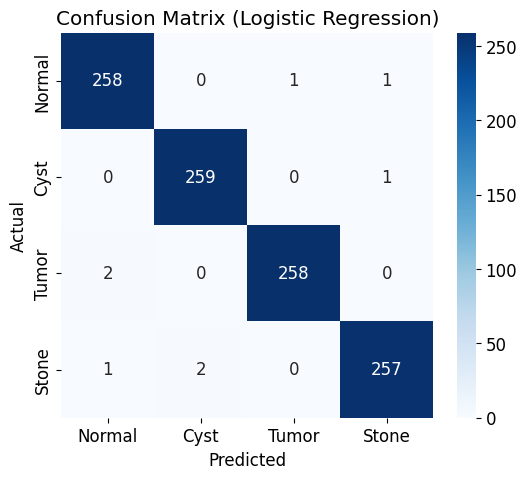

In [110]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [111]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       260
           1       0.99      1.00      1.00       260
           2       0.99      0.99      0.99       260
           3       1.00      0.99      0.99       260

    accuracy                           0.99      1040
   macro avg       0.99      0.99      0.99      1040
weighted avg       0.99      0.99      0.99      1040



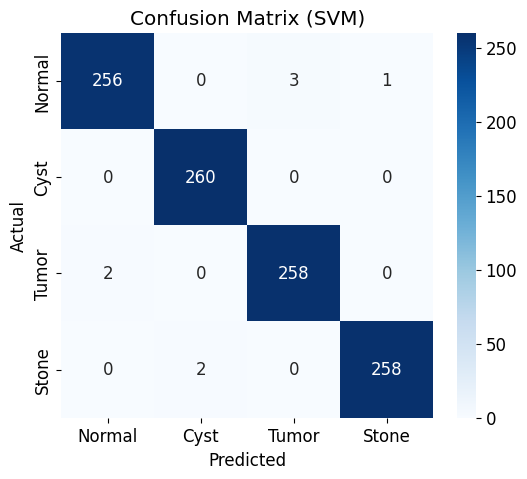

In [112]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Total misclassified images: 8


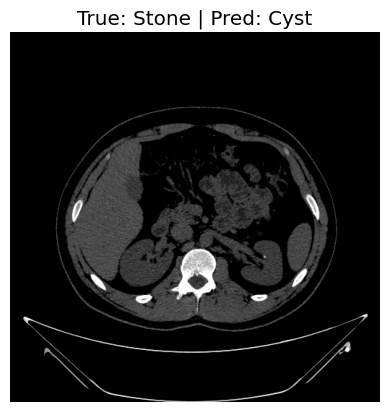

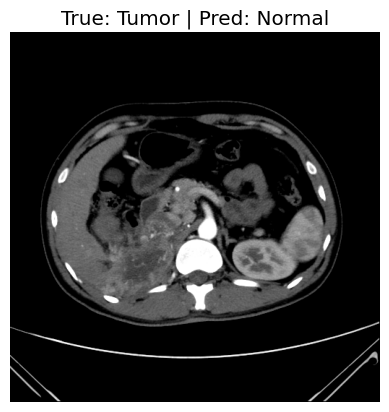

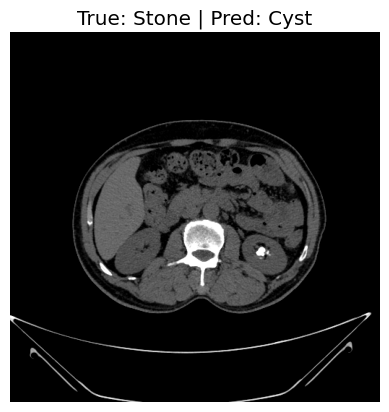

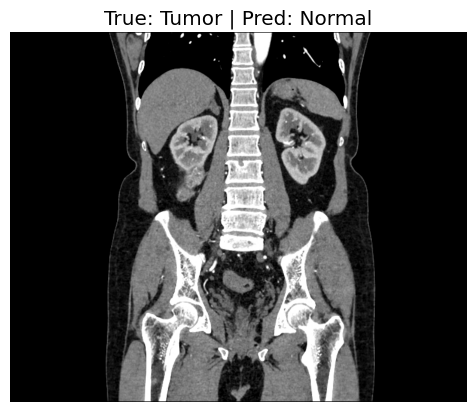

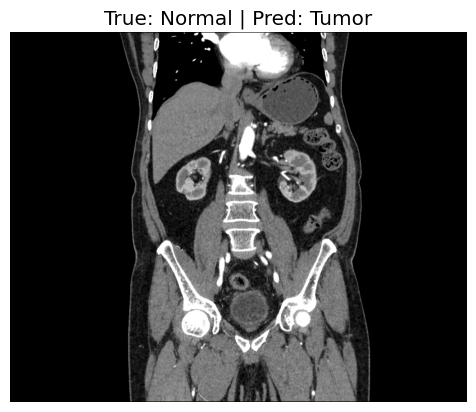

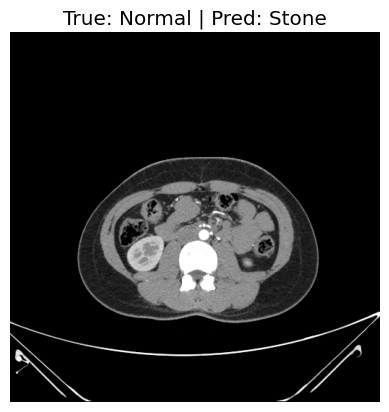

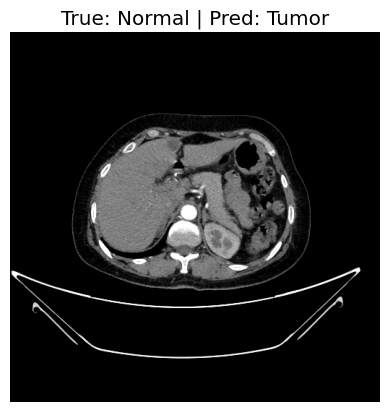

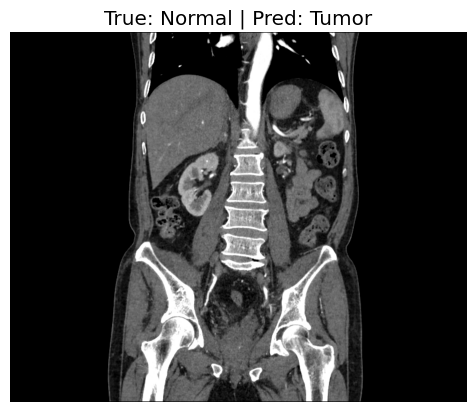

In [114]:
import matplotlib.pyplot as plt
import random
from IPython.display import display
from PIL import Image

wrong_idx = np.where(y_test != y_pred)[0]
print(f"Total misclassified images: {len(wrong_idx)}")

# Display few misclassified samples
num_samples = min(8, len(wrong_idx))
sample_idx = random.sample(list(wrong_idx), num_samples)

for idx in sample_idx:
    file_path = test_df.iloc[idx]['file_path']
    true_label = classes[int(y_test[idx])]
    pred_label = classes[int(y_pred[idx])]

    img = Image.open(file_path)
    plt.imshow(img)
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()
